In [10]:
import time
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imutils
import matplotlib.image as mpimg
from collections import OrderedDict
from skimage import io, transform
from math import *
import xml.etree.ElementTree as ET 

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [11]:
class Network(nn.Module):
    def __init__(self,num_classes=136):
        super().__init__()
        self.model_name='resnet34'
        self.model=models.resnet34()
        self.model.conv1=nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        #self.model.conv1=nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=0, bias=False)
        #self.model.conv1=nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=2, bias=False)
        self.model.fc=nn.Linear(self.model.fc.in_features, num_classes)
        
    def forward(self, x):
        x=self.model(x)
        return x

(1, 1, 224, 224)
(224, 224)


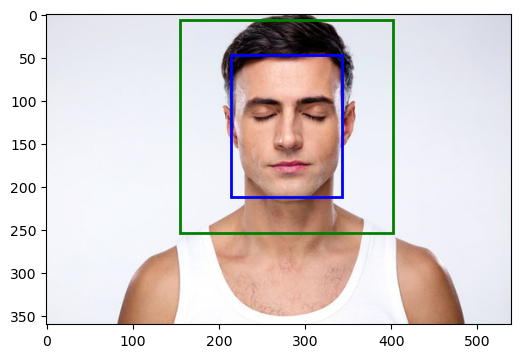

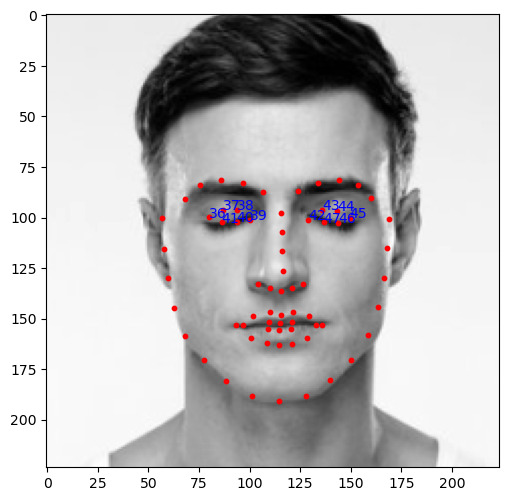

In [13]:
import PIL
import matplotlib.patches as patches
import torchvision.transforms.functional as TF
imgdir = './Pet.jpg'
frame = cv2.imread(imgdir)

net = cv2.dnn.readNetFromCaffe('./openCV_models/deploy.prototxt.txt',
                               './openCV_models/res10_300x300_ssd_iter_140000.caffemodel')
(h, w) = frame.shape[:2]
blob = cv2.dnn.blobFromImage(cv2.resize(frame, (300,300)), 1.0, (300,300), (104.0, 177.0, 123.0))
net.setInput(blob)
detections = net.forward()
box = detections[0, 0, 0, 3:7] * np.array([w, h, w, h])
(l, t, r, b) = box.astype("int")

# Crop
width = (r-l)
height = (b-t)
case = "150"
if case == "100" :
    if(width>height):
        tt = t + 0.5*height - 0.5*width
        ll=l
        widthh = width
        heightt = width
    else :
        ll = l +0.5*width - 0.5*height
        tt=t
        widthh = height
        heightt = height
elif case == "150" :
    if(width > height) :
        widthh = width*1.5
        heightt = widthh
        tt = t + height*0.5 - heightt*0.5
        ll = l - width*0.25
    else :
        heightt = height*1.5
        widthh = heightt
        tt = t - height*0.25
        ll = l + width*0.5 - widthh*0.5
elif case =="144" :    
    side = (width*height)**0.5
    tt = t+height-side
    ll = l+0.5*width-0.5*side
    widthh = side
    heightt = side

img = PIL.Image.fromarray(frame)

R, G, B = img.split()
new_image = PIL.Image.merge("RGB", (B, G, R))

plt.figure(figsize=(600/100, 600/100), dpi=100)

ax = plt.gca()
ax.add_patch(
   patches.Rectangle(
      (l, t),                   # (x, y)
      width, height,                     # width, height
        lw = 2,
      edgecolor = 'b',
      fill=False,
   ))
ax.add_patch(
   patches.Rectangle(
      (ll, tt),                   # (x, y)
      widthh, heightt,                     # width, height
        lw = 2,
      edgecolor = 'g',
      fill=False,
   ))

plt.imshow(new_image)

frame = cv2.imread(imgdir, 0)
frame = Image.fromarray(frame)
frame = TF.crop(frame, tt, ll, heightt, widthh)
# Resize
frame = TF.resize(frame, (224,224))
# To Tensor
#img = TF.to_tensor(img)
frame = TF.to_tensor(frame)
#img = TF.normalize(img, [0.5], [0.5])
frame = TF.normalize(frame, [0.5], [0.5])

best_network = Network()
best_network.cuda()
best_network.load_state_dict(torch.load('./Vacancy_15.pth'))
best_network.eval()

#print(img.cpu().numpy().shape)
#img = img.unsqueeze(1)
frame = frame.unsqueeze(1)
#print(img.cpu().numpy().shape)
#img = img.cuda()
frame = frame.cuda()
#predictions = (best_network(img).cpu()+0.5)*224
#predictions = (best_network(frame).cpu()+0.5)*224
predictions = (best_network(frame).cpu())
predictions = predictions.view(-1, 68, 2)

plt.figure(figsize=(600/100, 600/100), dpi=100)
plt.scatter(predictions[0, :, 0].detach().numpy(), predictions[0, :, 1].detach().numpy(), c = 'red', s = 10)
for i in range(12):
    plt.annotate(str(i+36), (predictions[0, i+36, 0].detach().numpy(), predictions[0, i+36, 1].detach().numpy()), c = 'blue', fontsize=10)

print(frame.cpu().numpy().shape)
print(frame.cpu().numpy().squeeze().shape)
plt.imshow(frame.cpu().squeeze(), cmap='gray')